In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
from   tqdm import tqdm
import pickle

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network  import MLPClassifier
from sklearn.metrics         import accuracy_score
from sklearn.preprocessing   import StandardScaler
fraction = [i / 20 for i in range(1, 20)]          # fraction of training set

mycmap = "spring"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

plt.style.use(["science", "grid", "notebook"])

In [2]:
dname  = "./DATA/"
str0   = "_XGB_25.dat"
fnamex = dname + 'x' + str0
fnamey = dname + 'y' + str0
x      = np.loadtxt(fnamex, delimiter = " ", dtype = float)
y      = np.loadtxt(fnamey)
y      = y.astype(int)
N,L    = len(x), len(x[0])

def split_dataset(i, x, dimensionality_reduction = 0):
    f = fraction[i]
    N_train = int(f * N) #75% training -> 25% test
    #
    if dimensionality_reduction   == 1:
        x_tmp = np.array([x[:,0], x[:,1], x[:,2]]).T
    elif dimensionality_reduction == 2:
        x_tmp = np.array([x[:,0], x[:,1]]).T
    elif dimensionality_reduction == 3:
        x_tmp = np.array([x[:,0]]).T
    else:
        x_tmp = x
    #####
    #
    x_train, y_train = x_tmp[:N_train], y[:N_train]
    x_test,  y_test  = x_tmp[N_train:], y[N_train:]
    return x_train, y_train, x_test, y_test
#####

x_train, y_train, x_test, y_test = split_dataset(14, x)

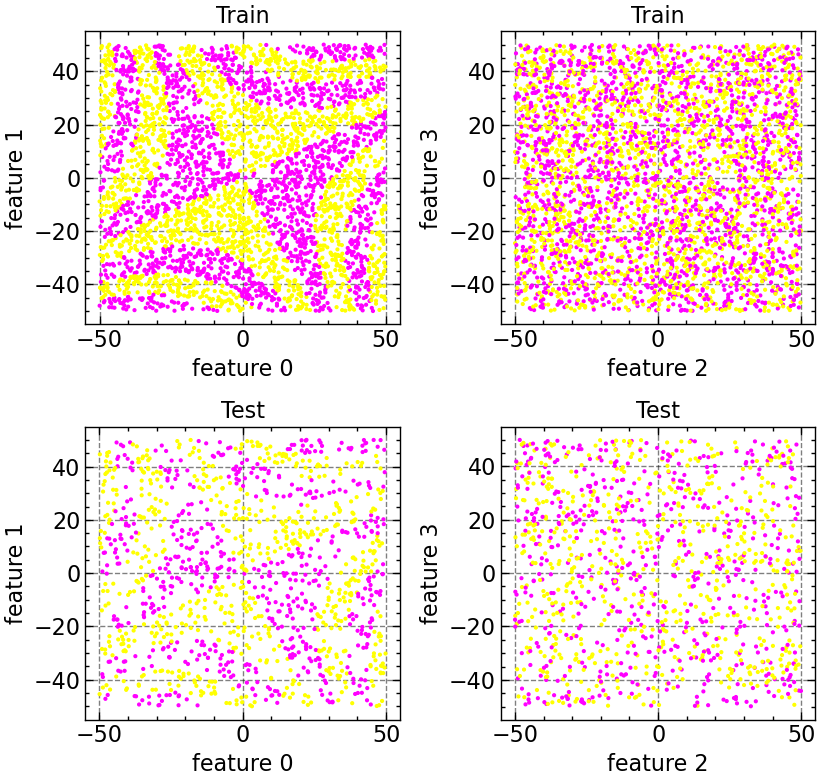

In [3]:
#original dataset visualization
def scatt(ax, x, y, i=0, j=1, s=4, title=""):
    ax.scatter(x[:,i], x[:,j], s=s, c=y)
    ax.set_xlabel(f'feature {i}')
    ax.set_ylabel(f'feature {j}')
    ax.set_title(title)

fig,ax=plt.subplots(2,2, figsize=(8.5,8.1))
scatt(ax[0,0], x_train, y_train, title='Train')
scatt(ax[0,1], x_train, y_train, i=2, j=3, title='Train')
scatt(ax[1,0], x_test, y_test, title='Test')
scatt(ax[1,1], x_test, y_test, i=2, j=3, title='Test')
plt.tight_layout()
plt.show()

errors: 6.64    accuracy=0.934


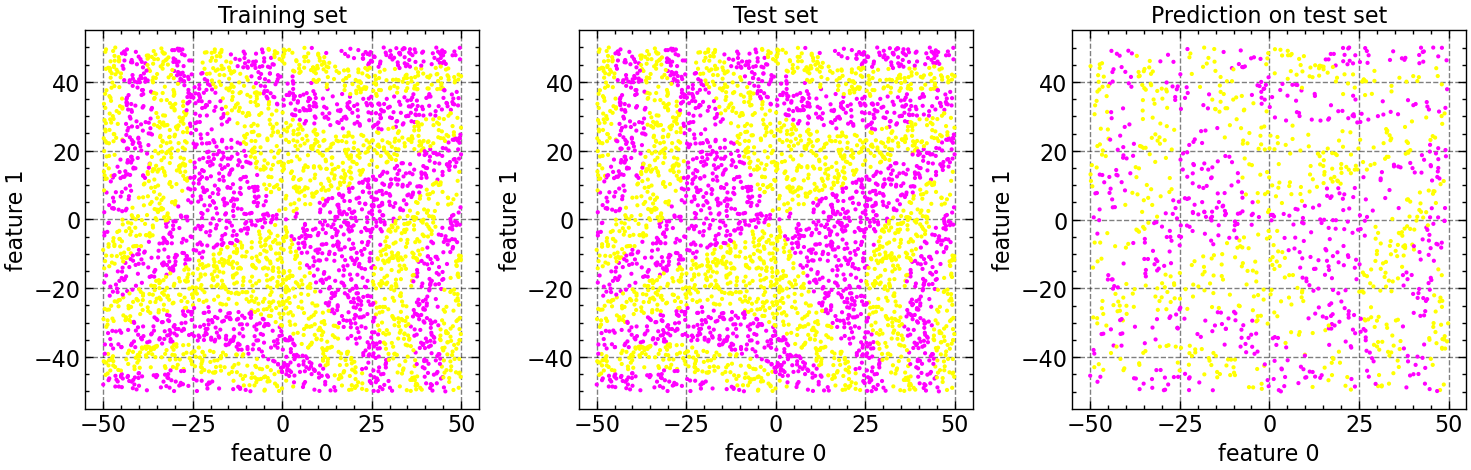

In [4]:
model = XGBClassifier(objective='binary:logistic', importance_type='gain')
#xgboost con diversi parametri
model.fit(x_train, y_train)
y_test_hat=model.predict(x_test)
print("errors: {:.2f}    accuracy={:.3f}".format(100*(1-model.score(x_test, y_test)), model.score(x_test, y_test)))

fig, ax = plt.subplots(1,3,figsize=(15,5))
scatt(ax[0], x_train, y_train, title='Training set')
scatt(ax[1], x_train, y_train, title='Test set')
scatt(ax[2], x_test, y_test_hat, title='Prediction on test set')
fig.tight_layout()
plt.show()

## 2. Dimensionality reduction

In [6]:
# best XGBClassifier model obtained from random search
def XGBClassifier_maker():
    best_XGBClassifier = XGBClassifier(objective       = 'binary:logistic',
                                       importance_type = 'gain',
                                       gamma           = 0,
                                       learning_rate   = 0.3,
                                       max_depth       = 7,
                                       n_estimators    = 90,
                                       reg_alpha       = 0.2,
                                       reg_lambda      = 0.8)
    ####################################
    #
    return best_XGBClassifier
#####

In [7]:
accuracies = []

def get_accuracies(reduction):
    best_XGBClassifier               = XGBClassifier_maker()
    x_train, y_train, x_test, y_test = split_dataset(fraction.index(0.95),
                                                     x,
                                                     dimensionality_reduction = reduction)
    best_XGBClassifier.fit(x_train, y_train)
    y_pred = best_XGBClassifier.predict(x_test)
    return accuracy_score(y_test, y_pred)
#####

accuracies.append(get_accuracies(0))   # all features
accuracies.append(get_accuracies(1))   # without L3
accuracies.append(get_accuracies(2))   # without both L3 and L2
accuracies.append(get_accuracies(3))   # only L1

In [8]:
accuracies

[0.948, 0.964, 0.964, 0.632]

## 3. XGBoost vs FFNN

Here XGBoost and feed-forward neural network (FFNN) are compared by computing accuracy score for both models. For each accuracy value an error effects the estimation; thus such error is obtained throught a cross-validation for each model.

In [11]:
def accuracy_generator(mlp, scale = False):
    def scaler(x_train, x_test):
        scaler = StandardScaler()
        x_tr   = scaler.fit_transform(x_train)
        x_te   = scaler.transform(x_test)
        return x_tr, x_te
    #####
    #
    def cross_validation(mlp, x_train, y_train, x_test, y_test):
        xsets = np.array(x_train)
        ysets = np.array(y_train)
        accuracies = []
        #
        for i in range(1, 11):
            x = xsets[(np.arange(len(xsets)) % 10) != i]
            y = ysets[(np.arange(len(xsets)) % 10) != i]
            mlp.fit(x, y)
            y_pred = mlp.predict(x_test)
            accuracies.append(accuracy_score(y_test, y_pred))
        #####
        #
        accuracies = np.array(accuracies)
        return accuracies.mean(), accuracies.std()
    #####
    #
    accuracies = []
    for i in tqdm(range(len(fraction))):
        x_train, y_train, x_test, y_test = split_dataset(i, x)
        if scale: x_train, x_test        = scaler(x_train, x_test)
        accuracies.append(cross_validation(mlp, x_train, y_train, x_test, y_test))
    #####
    accuracies = np.array(accuracies)
    #
    if str(mlp)[:3] == "MLP":
        accuracy_generator.MLP_accuracies.append(accuracies)
    elif str(mlp)[:3] == "XGB":
        accuracy_generator.XGB_accuracies.append(accuracies)
    else:
        print("'mlp' NOT supported")
    #####
#####

accuracy_generator.MLP_accuracies = []
accuracy_generator.XGB_accuracies = []

In [12]:
def make_plot(accuracies, title = "title", lim = (5, 100)):
    xdata = np.array(fraction) * 100
    ydata = accuracies * 100
    #
    plt.figure(figsize = (10, 6))
    plt.bar(xdata,
            ydata[:, 0],
            yerr    = ydata[:, 1],
            width   = 4,
            capsize = 6,
            color   = 'skyblue',
            alpha   = 0.9)
    #########
    plt.xlabel('Fraction of training set over whole set [%]')
    plt.xticks(np.arange(0, 101, 5))
    plt.ylabel('Accuracy [%]')
    plt.ylim(lim)
    plt.title(title)
    plt.grid(True)
    plt.show()
#####

In [13]:
def runs():
    try:
        accuracy_generator.MLP_accuracies = pickle.load(open("MLP_accuracies.pkl", "rb"))
    except:
        mlp_1 = MLPClassifier(hidden_layer_sizes = (10),  # one hidden layers, 10 neurons
                              max_iter           = 1000,  # maximum number of iterations
                              random_state       = 42)    # seed
        #######################
        #
        mlp_2 = MLPClassifier(hidden_layer_sizes = (25),   # one hidden layers, 25 neurons
                              max_iter           = 1000,   # maximum number of iterations
                              random_state       = 42)     # seed
        #######################
        #
        mlp_3 = MLPClassifier(hidden_layer_sizes = (10, 10),   # two hidden layers, 10 neurons for each layer
                              max_iter           = 1000,
                              random_state       = 42)
        #######################
        #
        mlp_4 = MLPClassifier(hidden_layer_sizes = (18, 18),   # two hidden layers, 18 neurons for each layer
                              max_iter           = 1000,
                              random_state       = 42)
        #######################
        #
        mlp_5 = MLPClassifier(hidden_layer_sizes = (18, 25, 18),   # three hidden layers
                              max_iter           = 1000,
                              random_state       = 42)
        #######################
        #
        accuracy_generator(mlp_1, scale = True)
        accuracy_generator(mlp_2, scale = True)
        accuracy_generator(mlp_3, scale = False)
        accuracy_generator(mlp_4, scale = False)
        accuracy_generator(mlp_5, scale = False)
        #
        pickle.dump(accuracy_generator.MLP_accuracies, open("MLP_accuracies.pkl", "wb"))
    #####
#####

runs()

In the following graph it is shown the accuracy for Feed-Forward Neural Networks (FFNN); the Network is set with two hidden layers of ten neurons each. Others network configuration, with more or less bot layers and neurons are checked without qualitative changes. Each error bar is the standard deviation of a set of ten accuracies, each computed with a different composition of the training set; the same procedure is followed for the accuracy estimation of the XGBoost graph.

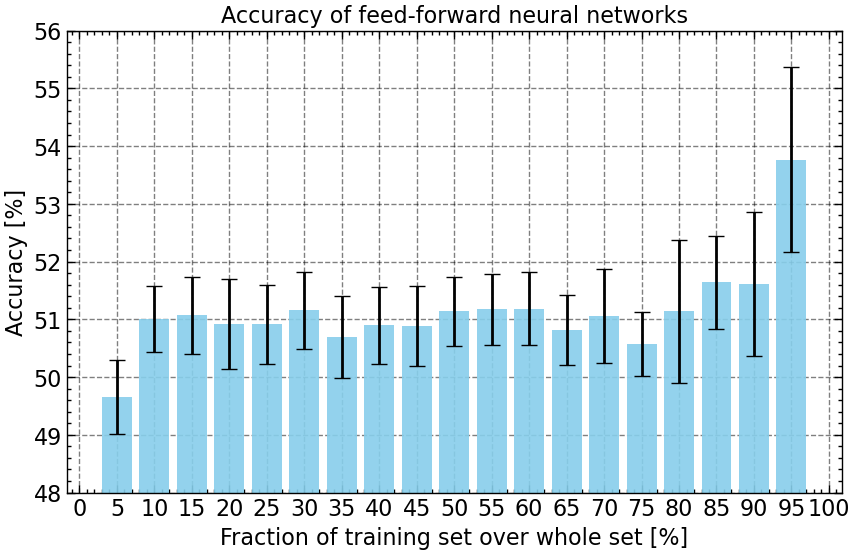

In [21]:
make_plot(accuracy_generator.MLP_accuracies[-3],
          "Accuracy of feed-forward neural networks", lim = (48, 56))

As we can see, the model (FFNN) is not able to learn for any fraction of the training set. Similar models are checked with comparable results.

In [23]:
accuracy_generator(XGBClassifier_maker(), scale = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:21<00:00,  1.12s/it]


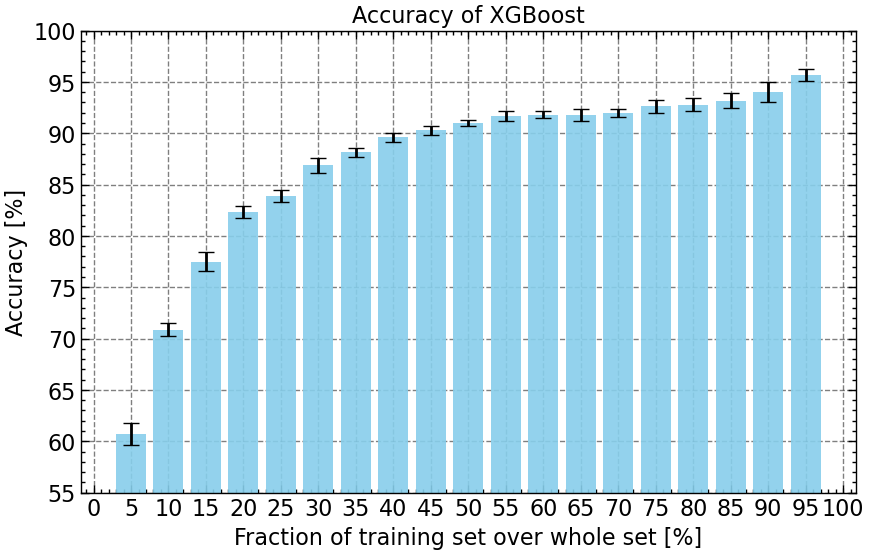

In [24]:
make_plot(np.array(accuracy_generator.XGB_accuracies)[-1],
          "Accuracy of XGBoost", lim = (55, 100))

Here the accuracy of XGBoost is shown for each fraction of the training set. Performance of the XGBoost model are much greater both for high and low value of the fraction of the training set actual used for the training. Even at the lowest value of the fraction ($5%$) XGBoost has an accuracy greater then the best accuracy value of the (FFNN).

In [ ]:
## MAYBE (TO DO)
"""
def make_plot(accuracies, title = "title", lim = (5, 100)):
    xdata = np.array(fraction) * 100
    ydata = accuracies * 100
    #
    plt.figure(figsize = (10, 6))
    legend = ["(10)", "(25)", "(10, 10)", "(18, 18)", "(18, 25, 18)"]
    for item, l in zip(accuracies, legend):
        plt.bar(xdata,
                item[:, 0],
                yerr    = item[:, 1],
                width   = 4,
                capsize = 1,
                color   = 'skyblue',
                alpha   = 0.9,
                label   = l)
        #########
    #####
    plt.xlabel('Fraction of training set over whole set [%]')
    plt.xticks(np.arange(0, 101, 5))
    plt.ylabel('Accuracy [%]')
    plt.ylim(lim)
    plt.title(title)
    plt.grid(True)
    plt.show()
#####
"""